<a href="https://colab.research.google.com/github/CamyllaTahara/MachineLearning/blob/main/cnn_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import IPython.display as display
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os,random
import matplotlib.pyplot as plt

In [ ]:
! git clone https://github.com/MarcioPAraujo/cnn_covid19_lungs.git

fatal: destination path 'cnn_covid19_lungs' already exists and is not an empty directory.


In [ ]:
IMAGE_HEIGHT=128
IMAGE_WIDTH=128
BATCH_SIZE=128
def get_pathframe(path):
  '''
  Obtém todos os caminhos das imagens e seus rótulos correspondentes e armazena
  no dataframe do pandas
  '''
  filenames = os.listdir(path)
  categories = []
  paths=[]
  for filename in filenames:
    paths.append(path+filename)
    category = filename.split('-')[0]
    if category == 'Lung_Opacity':
      categories.append(0)
    elif category == 'Viral Pneumonia':
      categories.append(1)
    elif category == 'Normal':
      categories.append(2)
    else:
      categories.append(3)

  df= pd.DataFrame({
      'filename': filenames,
      'category': categories,
      'paths':paths
  })
  return df

In [ ]:
covid_df = get_pathframe('cnn_covid19_lungs/COVID-19_Radiography_Dataset/COVID/')
lung_opcity_df = get_pathframe('cnn_covid19_lungs/COVID-19_Radiography_Dataset/Lung_Opacity/')
normal_df = get_pathframe('cnn_covid19_lungs/COVID-19_Radiography_Dataset/Normal/')
viral_pneumonia_df = get_pathframe('cnn_covid19_lungs/COVID-19_Radiography_Dataset/Viral_Pneumonia/')

combined_df = pd.concat([covid_df, lung_opcity_df, normal_df, viral_pneumonia_df], ignore_index=True)
print(combined_df)

                       filename  category  \
0                 COVID-978.png         3   
1                COVID-3148.png         3   
2                COVID-2855.png         3   
3                COVID-3350.png         3   
4                COVID-1127.png         3   
...                         ...       ...   
21160   Viral Pneumonia-376.png         1   
21161   Viral Pneumonia-948.png         1   
21162  Viral Pneumonia-1146.png         1   
21163   Viral Pneumonia-856.png         1   
21164   Viral Pneumonia-600.png         1   

                                                   paths  
0      cnn_covid19_lungs/COVID-19_Radiography_Dataset...  
1      cnn_covid19_lungs/COVID-19_Radiography_Dataset...  
2      cnn_covid19_lungs/COVID-19_Radiography_Dataset...  
3      cnn_covid19_lungs/COVID-19_Radiography_Dataset...  
4      cnn_covid19_lungs/COVID-19_Radiography_Dataset...  
...                                                  ...  
21160  cnn_covid19_lungs/COVID-19_Radiography_

In [ ]:
import tensorflow as tf

def load_and_preprocess_xray(path):
    """
    Load and preprocess X-ray images for machine learning models.
    - Reads the image file.
    - Converts to grayscale (most X-ray images are single-channel).
    - Normalizes pixel values.
    - Resizes to a standard size.
    - Applies optional histogram equalization for better contrast.

    Args:
        path (str): Path to the image file.

    Returns:
        tf.Tensor: Preprocessed image tensor.
    """
    # Load image
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=1)  # Convert to grayscale (1 channel)

    # Normalize to [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Resize to the desired dimensions
    image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    return image

def convert_to_tensor(df):
  #Converte cada dado e rótulo em um tensor
  path_ds = tf.data.Dataset.from_tensor_slices(df['paths'])
  image_ds = path_ds.map(load_and_preprocess_xray)
  # onehot_label=tf.one_hot(tf.cast(df['category'], tf.int64),2) if using softmax
  onehot_label=tf.cast(df['category'], tf.int64)
  label_ds = tf.data.Dataset.from_tensor_slices(onehot_label)

  return image_ds,label_ds

In [ ]:
X,Y=convert_to_tensor(combined_df)
print("Shape of X in data:", X)
print("Shape of Y in data:", Y)

Shape of X in data: <_MapDataset element_spec=TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None)>
Shape of Y in data: <_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>


In [ ]:
dataset=tf.data.Dataset.zip((X,Y)).shuffle(buffer_size=2000)
dataset_train=dataset.take(22500)
dataset_test=dataset.skip(22500)

dataset_train=dataset_train.batch(BATCH_SIZE, drop_remainder=True)
dataset_test=dataset_test.batch(BATCH_SIZE, drop_remainder=True)
dataset_train

<_BatchDataset element_spec=(TensorSpec(shape=(128, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(128,), dtype=tf.int64, name=None))>

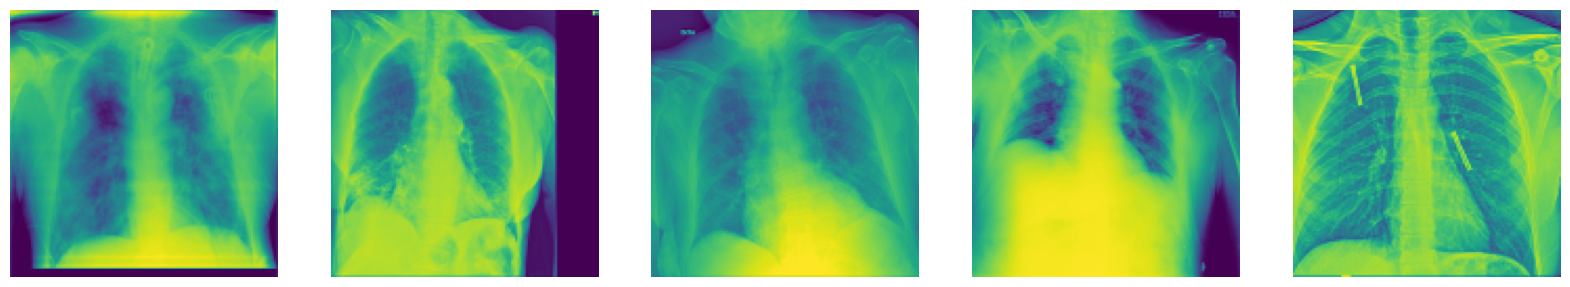

In [ ]:
def plotimages(imagesls):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for image,ax in zip(imagesls, axes):
    ax.imshow(image)
    ax.axis('off')

imagesls=[]
for n, image in enumerate(X.take(5)):
  imagesls.append(image)

plotimages(imagesls)

In [ ]:
def My_CNNmodel():

  model = tf.keras.models.Sequential()
  model.add(layers.Conv2D(8, (3, 3), padding='same',activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(16, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Conv2D(32, (3, 3), padding='same',activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid')) # softmax

  opt=tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer=opt,
              loss='binary_crossentropy', # loss='categorical_crossentropy' if softmax
              metrics=['accuracy'])

  return model

In [ ]:
model=My_CNNmodel()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 32)       

In [ ]:
dataset=tf.data.Dataset.zip((X,Y)).shuffle(buffer_size=2000)
# Calculate the actual size of the dataset
dataset_size = len(list(dataset))

# Calculate split points based on the dataset size
train_size = int(0.75 * dataset_size)  # Adjust split ratio as needed

dataset_train = dataset.take(train_size)
dataset_test = dataset.skip(train_size)

dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)
dataset_test = dataset_test.batch(BATCH_SIZE, drop_remainder=True)
dataset_train
hist=model.fit(dataset_train,epochs=2,validation_data=dataset_test)

Epoch 1/2


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_2' (type Sequential).
    
    Input 0 of layer "conv2d_6" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (128, 128, 128, 1)
    
    Call arguments received by layer 'sequential_2' (type Sequential):
      • inputs=tf.Tensor(shape=(128, 128, 128, 1), dtype=float32)
      • training=True
      • mask=None


In [ ]:
model.save("my_model.keras")

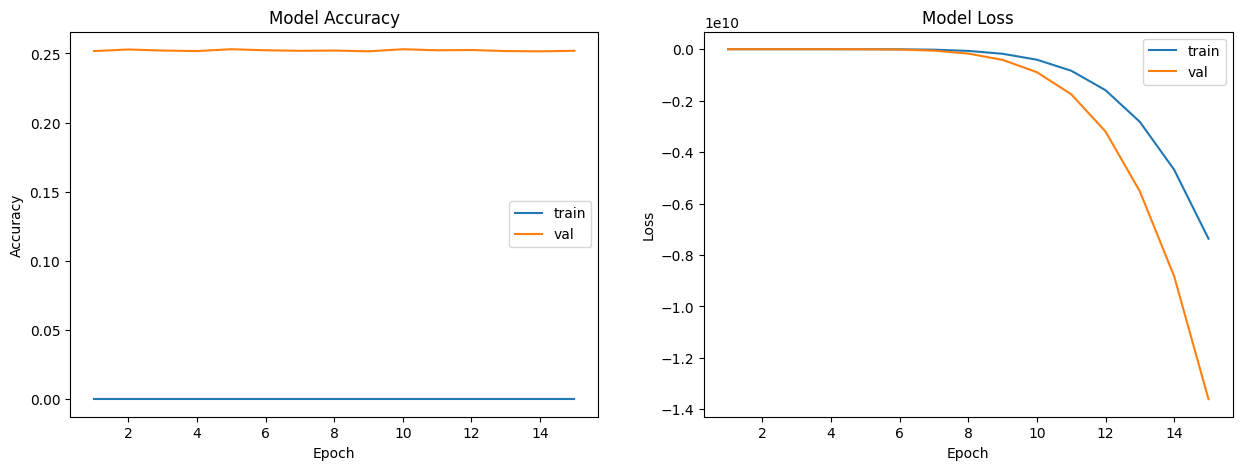

In [ ]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_model_history(hist)

41/41 [==============================] - 25s 290ms/step - loss: -13495840768.0000 - accuracy: 0.2532
Test: accuracy = 0.2532  ;  loss = -13495840768.0000
41/41 [==============================] - 26s 330ms/step


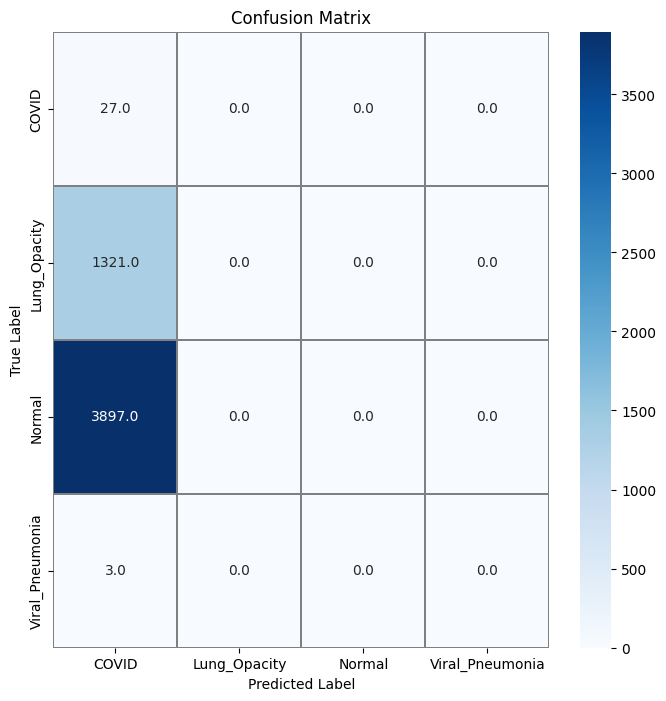

                 precision    recall  f1-score   support

          COVID       0.01      1.00      0.01        27
   Lung_Opacity       0.00      0.00      0.00      1321
         Normal       0.00      0.00      0.00      3897
Viral_Pneumonia       0.00      0.00      0.00         3

       accuracy                           0.01      5248
      macro avg       0.00      0.25      0.00      5248
   weighted avg       0.00      0.01      0.00      5248



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(dataset_test)
print(f"Test: accuracy = {accuracy:.4f}  ;  loss = {loss:.4f}")

# Predict the labels for the test dataset
y_pred = model.predict(dataset_test)

# Get the predicted class labels by selecting the class with the highest probability
y_p = np.argmax(y_pred, axis=1)

# Unbatch the test dataset and collect true labels
test_data = dataset_test.unbatch()
y_g = []  # True labels
for image, label in test_data:
    y_g.append(label.numpy())

# Convert y_g into a numpy array
y_g = np.array(y_g)

# Generate the confusion matrix
confusion_mtx = confusion_matrix(y_g, y_p)

# Plot the confusion matrix using a heatmap
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='.1f', cmap="Blues", linewidths=0.01, linecolor="gray", ax=ax,
            xticklabels=["COVID", "Lung_Opacity", "Normal", "Viral_Pneumonia"],
            yticklabels=["COVID", "Lung_Opacity", "Normal", "Viral_Pneumonia"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report for more detailed metrics
print(classification_report(y_g, y_p, target_names=["COVID", "Lung_Opacity", "Normal", "Viral_Pneumonia"]))
